In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 12.2 MB/s eta 0:00:00



0: 320x640 1 Goldfish, 1 Angel, 132.6ms
Speed: 13.6ms preprocess, 132.6ms inference, 332.6ms postprocess per image at shape (1, 3, 320, 640)


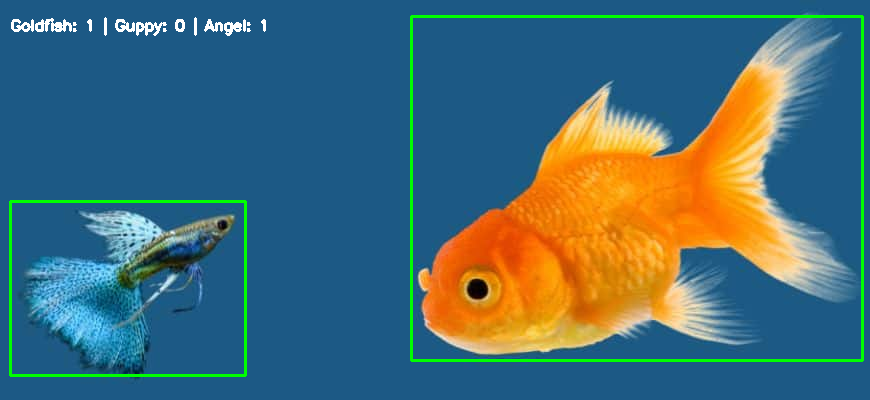

In [3]:
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from ultralytics import YOLO
from ultralytics.utils.files import increment_path

fish_counts = {'Goldfish': 0, 'Guppy': 0, 'Angel': 0}

def run(
    weights='/content/drive/MyDrive/best.pt',
    source=None,
    device='cpu',
    view_img=False,
    save_img=False,
    exist_ok=False,
    line_thickness=2,
):
    global fish_counts

    # Check source path
    if not Path(source).exists():
        raise FileNotFoundError(f"Source path '{source}' does not exist.")

    # Setup Model
    model = YOLO(weights)
    model.to('cuda') if device == 'cuda' else model.to('cpu')

    # Read the input image
    frame = cv2.imread(source)

    # Extract the results for the current frame
    results = model(frame)

    # Reset counts for each fish type in this frame
    fish_counts = {name: 0 for name in fish_counts}

    # Iterate over each result in the list
    for result in results:
        # Access the xyxy property and confidence values
        xyxy = result.boxes.xyxy.cpu().numpy()
        conf = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()

        for (x1, y1, x2, y2), c, class_id in zip(xyxy, conf, class_ids):
            fish_type = model.names[class_id]

            # Draw bounding box
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), line_thickness)

            # Display count on the frame at top-right corner
            fish_counts[fish_type] += 1

    # Display the counts on the frame at top-right corner
    count_label = " | ".join([f'{name}: {count}' for name, count in fish_counts.items()])
    cv2.putText(frame, count_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with fish count
    if view_img:
        cv2_imshow(frame)

    # Save the frame if specified
    if save_img:
        output_path = Path('/content/drive/MyDrive/Prediction 3') / 'exp' / f'{Path(source).stem}_counted.jpg'
        cv2.imwrite(str(output_path), frame)

# Example usage in Colab
weights_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/TrainYOLOv8CustomDataset/data/images/Videos_Test/Guppy-and-goldfish.jpg'

run(weights=weights_path, source=image_path, device='cuda', view_img=True, save_img=True)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from ultralytics import YOLO
from ultralytics.utils.files import increment_path

fish_counts = {'Goldfish': 0, 'Guppy': 0, 'Angel': 0}

def run(
    weights='/content/drive/MyDrive/best.pt',
    source=None,
    device='cpu',
    view_img=False,
    save_img=False,
    save_video=True,
    exist_ok=False,
    line_thickness=2,
):
    global fish_counts

    vid_frame_count = 0

    # Check source path
    if not Path(source).exists():
        raise FileNotFoundError(f"Source path '{source}' does not exist.")

    # Setup Model
    model = YOLO(weights)
    model.to('cuda') if device == 'cuda' else model.to('cpu')

    # Video setup
    videocapture = cv2.VideoCapture(source)
    frame_width, frame_height = int(videocapture.get(3)), int(videocapture.get(4))
    fps, fourcc = int(videocapture.get(5)), cv2.VideoWriter_fourcc(*'mp4v')

    # Output setup
    save_dir = increment_path(Path('/content/drive/MyDrive/Prediction 2') / 'exp', exist_ok) #Output Save Location
    save_dir.mkdir(parents=True, exist_ok=True)
    video_writer = cv2.VideoWriter(str(save_dir / f'{Path(source).stem}_counted.mp4'), fourcc, fps, (frame_width, frame_height))

    # Iterate over video frames
    while videocapture.isOpened():
        success, frame = videocapture.read()
        if not success:
            break
        vid_frame_count += 1

        # Extract the results for the current frame
        results = model(frame)

        # Reset counts for each fish type in this frame
        fish_counts = {name: 0 for name in fish_counts}

        # Iterate over each result in the list
        for result in results:
            # Access the xyxy property and confidence values
            xyxy = result.boxes.xyxy.cpu().numpy()
            conf = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy()

            for (x1, y1, x2, y2), c, class_id in zip(xyxy, conf, class_ids):
                fish_type = model.names[class_id]

                # Draw bounding box
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), line_thickness)

                # Display count on the frame at top-right corner
                fish_counts[fish_type] += 1

        # Display the counts on the frame at top-right corner
        count_label = " | ".join([f'{name}: {count}' for name, count in fish_counts.items()])
        cv2.putText(frame, count_label, (frame_width - 300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Display the frame with fish count
        if view_img:
            cv2_imshow(frame)

        # Save the frame if specified
        if save_img:
            cv2.imwrite(f'output_frame_{vid_frame_count}.jpg', frame)

        # Write the frame to the output video
        if save_video:
            video_writer.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    del vid_frame_count
    video_writer.release()
    videocapture.release()

# Example usage in Colab
weights_path = '/content/drive/MyDrive/best.pt'
video_path = '/content/drive/MyDrive/TrainYOLOv8CustomDataset/data/images/Videos_Test/stock-footage-fan-tailed-goldfish-swimming-in-a-fish-tank-slow-motion (1).webm'

run(weights=weights_path, source=video_path, device='cuda', view_img=True, save_img=False, save_video=True)